In [1]:
# ===== MEDICAL APPOINTMENT NO SHOWS =====

# Medical Appointment No-Show Prediction (EDA & Modeling)

## Overview
This notebook explores and models a real-world dataset from Brazilian medical appointments to understand the factors influencing whether patients show up for their appointments. The aim is to perform thorough **exploratory data analysis (EDA)**, address **class imbalance**, and train a **Random Forest Classifier** to predict no-shows.

### Key Objectives:
- Understand dataset structure and clean anomalies.
- Perform feature engineering (e.g., wait times, encoding).
- Visualize relationships between variables and the no-show target.
- Handle imbalanced classes using **SMOTE** and class weights.
- Build and tune a **Random Forest Classifier** using **RandomizedSearchCV**.
- Evaluate model performance using appropriate classification metrics.


In [2]:
# ===================================
# 🏛 SETTING UP THE ENVIRONMENT
# ===================================

In [3]:
# Importing libraries for Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Setting the visual style for all the plots using seaborn
sns.set(style="whitegrid")

In [5]:
# ===================================
# 📚 LOADING THE DATASET
# ===================================

In [6]:
# Loading the CVS file into a Dataframe for a more organised structure and for Data Analysis
data = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")

In [7]:
#display the first 5 rows to confirm that it is loaded
print("✅ Dataset Preview")
print(data.head(5))

✅ Dataset Preview
      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0         

In [8]:
# ==========================================
# 🔎 BASIC EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================

In [9]:
# View the data and the data structure
print("✅ DataFrame info:")
print(data.info())
print("✅ Summary Statistics:")
print(data.describe())

✅ DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None
✅ Summary Statistics:
          PatientId  AppointmentID           

In [10]:
# Check for missing values and duplicates
print("Missing Values:")
print(data.isnull().sum())
print("Number of duplicate rows:")
print(data.duplicated().sum())

Missing Values:
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64
Number of duplicate rows:
0


In [11]:
# ===================================
# 🛁 CLEANING THE DATASET
# ===================================

In [12]:
# Remove rows with invalide age (-1)
data = data[data['Age']>=0]

In [13]:
# Convert date columns to datetime to to do arithmetic on the date and also to extract features like year, time etc if necessary
data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['AppointmentDay'] = pd.to_datetime(data["AppointmentDay"])

In [14]:
# Check that the data has converted correctly
print(data["ScheduledDay"].dtype)
print(data["AppointmentDay"].dtype)

datetime64[ns, UTC]
datetime64[ns, UTC]


In [15]:
# Create a new column: AwaitingTime (days between scheduling and appointment) to check correlation between scheduled dates and appointment dates timeframe
data["AwaitingTime"] = (data["AppointmentDay"] - data["ScheduledDay"]).dt.days
data["AwaitingTime"] = data["AwaitingTime"].abs()
# Let's verify
print("Preview the AwaitingTime column:")
print(data[["ScheduledDay", "AppointmentDay", "AwaitingTime"]].head())

Preview the AwaitingTime column:
               ScheduledDay            AppointmentDay  AwaitingTime
0 2016-04-29 18:38:08+00:00 2016-04-29 00:00:00+00:00             1
1 2016-04-29 16:08:27+00:00 2016-04-29 00:00:00+00:00             1
2 2016-04-29 16:19:04+00:00 2016-04-29 00:00:00+00:00             1
3 2016-04-29 17:29:31+00:00 2016-04-29 00:00:00+00:00             1
4 2016-04-29 16:07:23+00:00 2016-04-29 00:00:00+00:00             1


In [16]:
# ===================================
# 📊 NO-SHOW DISTRIBUTION
# ===================================

<ipython-input-17-3734edd734b4>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=no_show_counts.index, y=no_show_counts.values, palette="pastel")


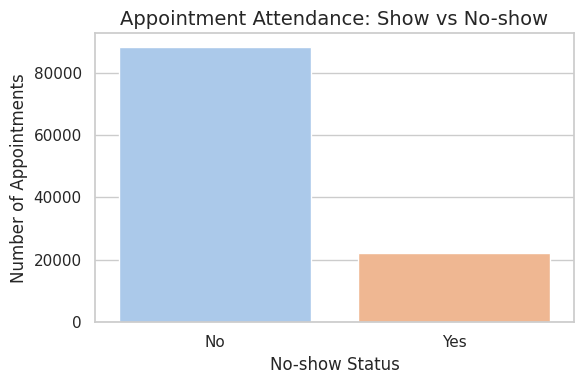

In [17]:
# Count of "No-show" values
no_show_counts = data["No-show"].value_counts()

# Plot the "No-show" diagram
plt.figure(figsize=(6, 4))
sns.barplot(x=no_show_counts.index, y=no_show_counts.values, palette="pastel")
plt.title("Appointment Attendance: Show vs No-show", fontsize=14)
plt.xlabel("No-show Status")
plt.ylabel("Number of Appointments")
plt.tight_layout()
plt.show

# Showing visual outside of vs code
plt.show(block=True)

In [18]:
# ===========================================
# 📊 RE-NAMING THE PLOT FOR EASE OF READING
# ===========================================

No-show
No     88207
Yes    22319
Name: count, dtype: int64


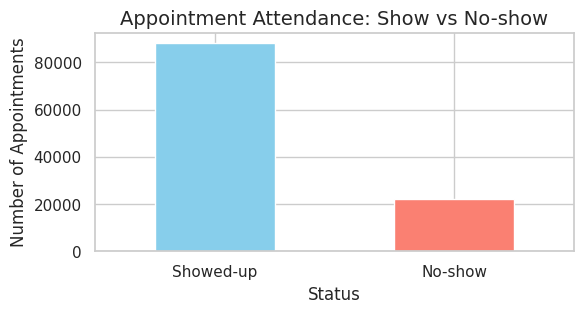

In [19]:
# Check plot again
print(data["No-show"].value_counts())
data["No-show"] = data["No-show"].replace({"No":"Showed-up", "Yes":"No-show"})

# Plot the "No-show" diagram
plt.figure(figsize=(6, 4))
data["No-show"].value_counts().plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Appointment Attendance: Show vs No-show", fontsize=14)
plt.xlabel("Status")
plt.ylabel("Number of Appointments")
plt.tight_layout()
plt.xticks(rotation=0)
plt.show

# Showing visual outside of vs code
plt.show(block=True)
plt.show(block=True)

In [20]:
# ===========================================
# 📝 EXPLORATORY DATA ANALYSIS - DEEP DIVE
# ===========================================

In [21]:
# Which factors influence whether a patient shows up for their appointment?

# ==================
# Rate by Gender
# ==================

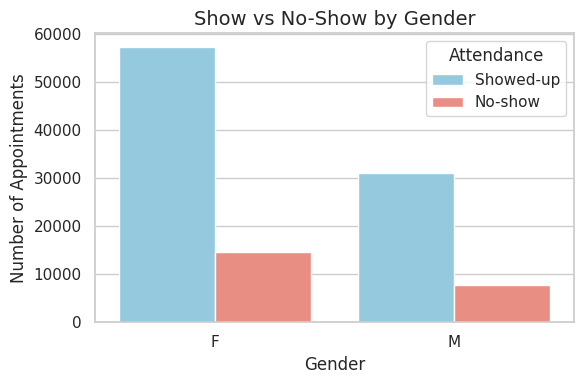

In [22]:
# Creating a grouped bar chart
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="Gender", hue="No-show", palette=["skyblue", "salmon"])

# Adding titles and labels
plt.title("Show vs No-Show by Gender", fontsize=14)
plt.xlabel("Gender")
plt.ylabel("Number of Appointments")
plt.legend(title="Attendance")
plt.tight_layout()
plt.show(block=True)

In [23]:
# ===========================================
# 🎂 AGE DISTRIBUTION BY SHOW STATUS
# ===========================================

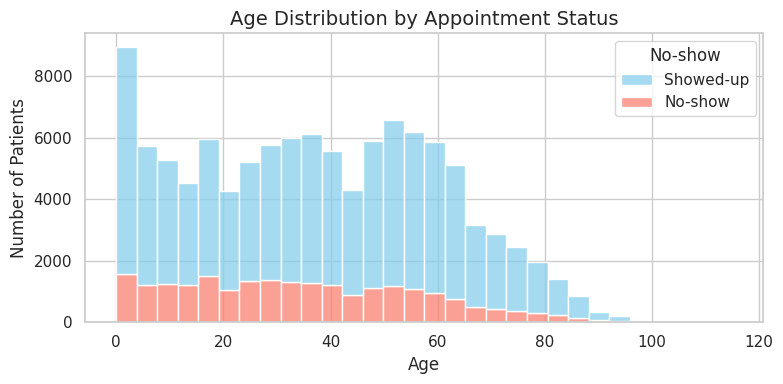

In [24]:
plt.figure(figsize=(8, 4))
sns.histplot(data=data, x="Age", hue="No-show", multiple="stack", bins=30, palette=["skyblue", "salmon"])
plt.title("Age Distribution by Appointment Status", fontsize=14)
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show(block=True)

In [25]:
# =================================
# ⏳ AWAITING TIME & NO-SHOWS
# =================================

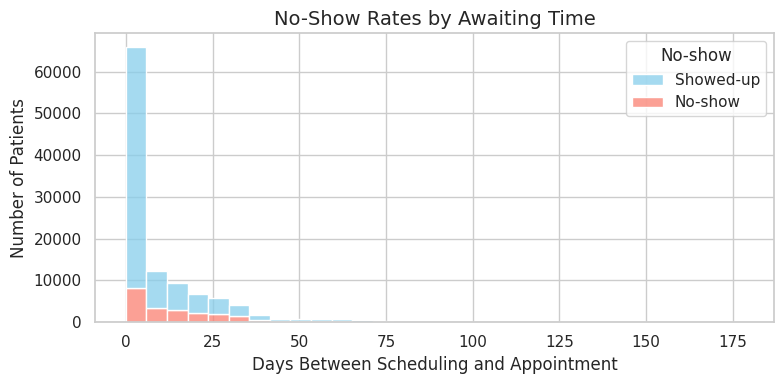

In [26]:
plt.figure(figsize=(8, 4))
sns.histplot(data=data, x="AwaitingTime", hue="No-show", multiple="stack", bins=30, palette=["skyblue", "salmon"])
plt.title("No-Show Rates by Awaiting Time", fontsize=14)
plt.xlabel("Days Between Scheduling and Appointment")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show(block=True)

In [27]:
# ==================================
# 📝 NO-SHOW RATE BY SCHOLARSHIP
# ==================================

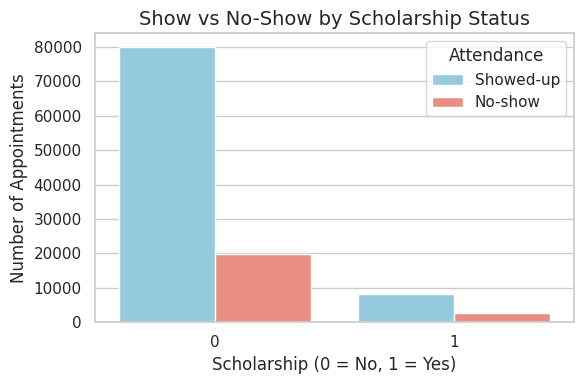

In [28]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="Scholarship", hue="No-show", palette=["skyblue", "salmon"])
plt.title("Show vs No-Show by Scholarship Status", fontsize=14)
plt.xlabel("Scholarship (0 = No, 1 = Yes)")
plt.ylabel("Number of Appointments")
plt.legend(title="Attendance")
plt.tight_layout()
plt.show(block=True)

In [29]:
# =============================
# 📲 SMS REMINDER IMPACT
# =============================

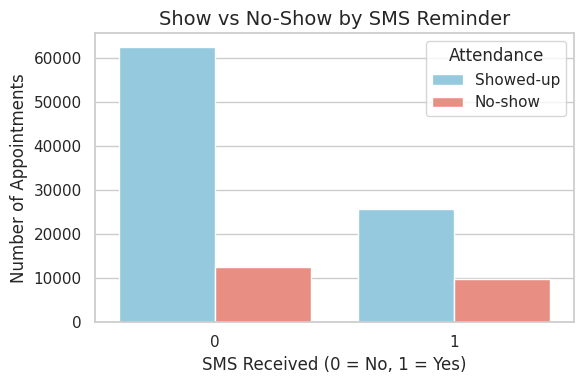

In [30]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="SMS_received", hue="No-show", palette=["skyblue", "salmon"])
plt.title("Show vs No-Show by SMS Reminder", fontsize=14)
plt.xlabel("SMS Received (0 = No, 1 = Yes)")
plt.ylabel("Number of Appointments")
plt.legend(title="Attendance")
plt.tight_layout()
plt.show(block=True)

In [31]:
# =============================
# ♿️ HANDICAP VS NO-SHOW
# =============================

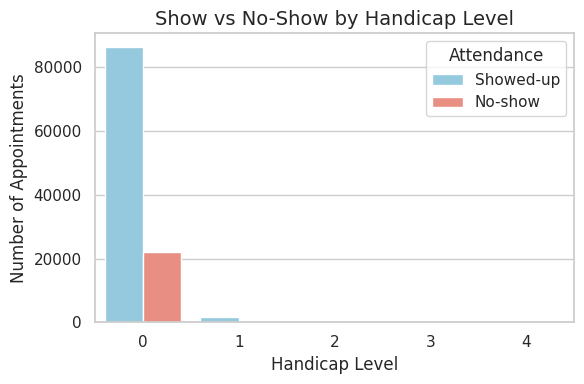

In [32]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="Handcap", hue="No-show", palette=["skyblue", "salmon"])
plt.title("Show vs No-Show by Handicap Level", fontsize=14)
plt.xlabel("Handicap Level")
plt.ylabel("Number of Appointments")
plt.legend(title="Attendance")
plt.tight_layout()
plt.show(block=True)

In [33]:
# ================================
# HIPERTENSION SHOW VS NO-SHOW
# ================================

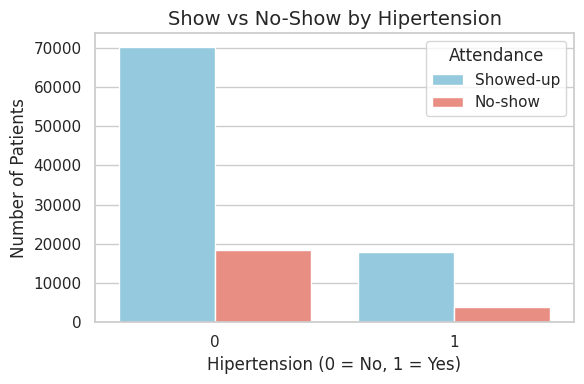

In [34]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="Hipertension", hue="No-show", palette=["skyblue", "salmon"])
plt.title("Show vs No-Show by Hipertension", fontsize=14)
plt.xlabel("Hipertension (0 = No, 1 = Yes)")
plt.ylabel("Number of Patients")
plt.legend(title="Attendance")
plt.tight_layout()
plt.show(block=True)

In [35]:
# ==============================
# DIABETES SHOW VS NO-SHOW
# ==============================

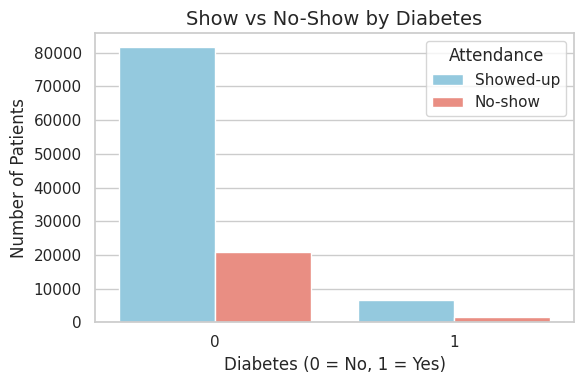

In [36]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="Diabetes", hue="No-show", palette=["skyblue", "salmon"])
plt.title("Show vs No-Show by Diabetes", fontsize=14)
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("Number of Patients")
plt.legend(title="Attendance")
plt.tight_layout()
plt.show(block=True)

In [37]:
# ==============================
# ALCOHOLISM SHOW VS NO-SHOW
# ==============================

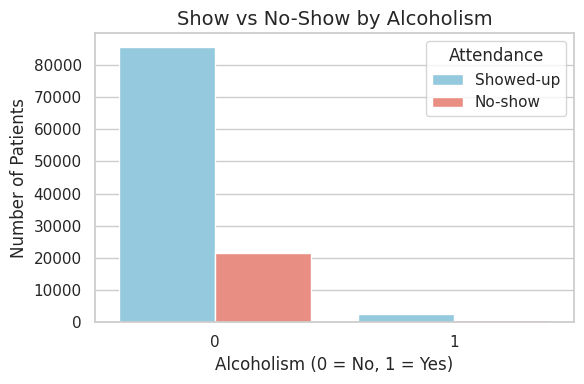

In [38]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="Alcoholism", hue="No-show", palette=["skyblue", "salmon"])
plt.title("Show vs No-Show by Alcoholism", fontsize=14)
plt.xlabel("Alcoholism (0 = No, 1 = Yes)")
plt.ylabel("Number of Patients")
plt.legend(title="Attendance")
plt.tight_layout()
plt.show(block=True)

In [39]:
# =====================================
# PRE-PROCESSING DATA FOR CORRELATION
# =====================================

In [40]:
# Convert categorical text into numerical text format for correlation


In [41]:
# Copy the data to avoid duplication / midification
df = data.copy()

df["No-show"] = df["No-show"].map({"No-show": 1, "Showed-up": 0})
df["Gender"] = df["Gender"].map({"F": 1, "M": 0})

print(df["No-show"].value_counts(dropna=False))

No-show
0    88207
1    22319
Name: count, dtype: int64


In [42]:
numeric_df = df.select_dtypes(include=["number"])
correlation_matrix = numeric_df.corr()
print(correlation_matrix)

print("\nIs 'No-show' in the correlation matrix?")
print("No-show" in correlation_matrix.columns)

               PatientId  AppointmentID    Gender       Age  Scholarship  \
PatientId       1.000000       0.004023 -0.007898 -0.004121    -0.002877   
AppointmentID   0.004023       1.000000 -0.018506 -0.019106     0.022619   
Gender         -0.007898      -0.018506  1.000000  0.106452     0.114296   
Age            -0.004121      -0.019106  0.106452  1.000000    -0.092463   
Scholarship    -0.002877       0.022619  0.114296 -0.092463     1.000000   
Hipertension   -0.006436       0.012759  0.055722  0.504586    -0.019730   
Diabetes        0.001608       0.022632  0.032556  0.292391    -0.024894   
Alcoholism      0.011014       0.032946 -0.106166  0.095810     0.035022   
Handcap        -0.007915       0.014107 -0.022813  0.078032    -0.008587   
SMS_received   -0.009742      -0.256613  0.046302  0.012633     0.001192   
No-show        -0.001456      -0.162597  0.004122 -0.060327     0.029134   
AwaitingTime   -0.000715      -0.769910  0.025938  0.030486    -0.029694   

           

In [43]:
# ============================
# 📊 PLOT THE HEATMAP
# ============================

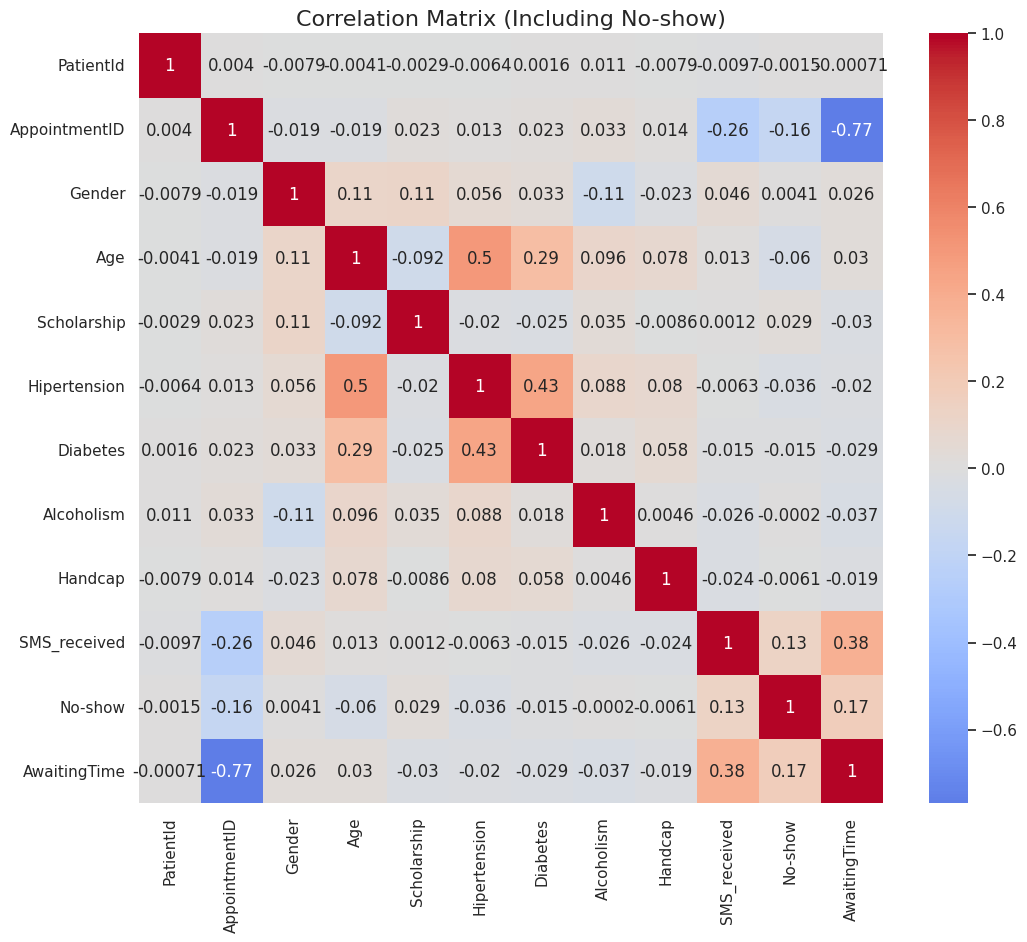

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix (Including No-show)", fontsize=16)
plt.show(block=True)

In [45]:
# ======================================================
# 📊 EXPLORING THE RELATIONSHIP FROM HEATMAP INSIGHTS
# ======================================================

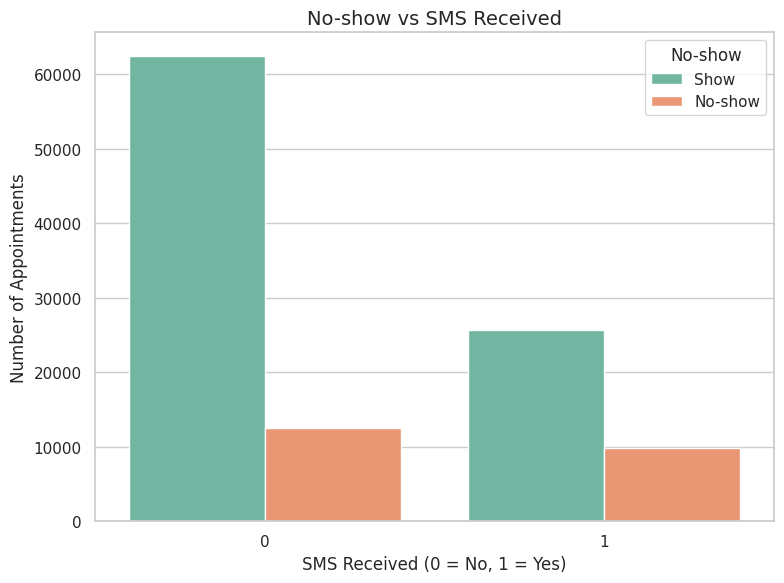

In [46]:
# Enable interactive mode for pop-up plots
plt.ion()

# SMS_received vs No-show visual
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='SMS_received', hue='No-show', palette='Set2')

plt.title('No-show vs SMS Received', fontsize=14)
plt.xlabel('SMS Received (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Number of Appointments', fontsize=12)

plt.legend(title='No-show', labels=['Show', 'No-show'])
plt.tight_layout()
plt.show(block=True)

SMS Outcomes (0=Showed, 1=No-show):
 No-show           0      1
SMS_received              
0             62509  12535
1             25698   9784
No-show rate by SMS_received:
 SMS_received
0    0.167035
1    0.275745
dtype: float64
AwaitingTime stats by SMS_received:
                 count       mean        std  min  25%   50%   75%    max
SMS_received                                                            
0             75044.0   6.035566  11.864400  0.0  1.0   1.0   5.0  178.0
1             35482.0  18.016713  16.978718  2.0  6.0  13.0  26.0  178.0
Unique No-show values: [0 1]
Unique SMS_received values: [0 1]


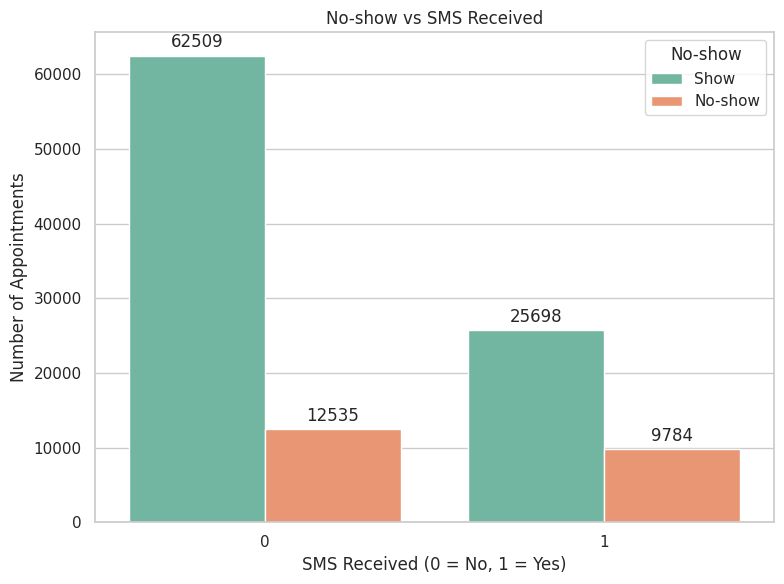

In [47]:

#======== How many people received an SMS and didn’t show up vs showed up?
# Count SMS_received vs No-show
sms_outcomes = df.groupby(['SMS_received', 'No-show']).size().unstack(fill_value=0)
print("SMS Outcomes (0=Showed, 1=No-show):\n", sms_outcomes)

#============= What is the no-show rate with and without SMS?
sms_totals = df.groupby('SMS_received').size()
sms_no_show_rate = df[df['No-show'] == 1].groupby('SMS_received').size() / sms_totals
print("No-show rate by SMS_received:\n", sms_no_show_rate)

#=========== Average AwaitingTime by SMS_received?
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['AwaitingTime'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days.abs()

awaiting_time_by_sms = df.groupby('SMS_received')['AwaitingTime'].describe()
print("AwaitingTime stats by SMS_received:\n", awaiting_time_by_sms)

#============  Barplot with counts + percentage annotations
print("Unique No-show values:", df['No-show'].unique())
print("Unique SMS_received values:", df['SMS_received'].unique())

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='SMS_received', hue='No-show', palette='Set2')

# Add annotations
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.title('No-show vs SMS Received')
plt.xlabel('SMS Received (0 = No, 1 = Yes)')
plt.ylabel('Number of Appointments')
plt.legend(title='No-show', labels=['Show', 'No-show'])
plt.tight_layout()
plt.show(block=True)

In [48]:
 #============ Is SMS effective? Calculate SMS effectiveness rate
# % of no-shows for each group
effectiveness = sms_no_show_rate[0] - sms_no_show_rate[1]
print(f"SMS reminder effectiveness rate: {effectiveness:.2%} reduction in no-shows")

print("Unique values in SMS_received:", df['SMS_received'].unique())
print("Unique values in No-show:", df['No-show'].unique())
print("Null values in SMS_received:", df['SMS_received'].isnull().sum())
print("Null values in No-show:", df['No-show'].isnull().sum())

SMS reminder effectiveness rate: -10.87% reduction in no-shows
Unique values in SMS_received: [0 1]
Unique values in No-show: [0 1]
Null values in SMS_received: 0
Null values in No-show: 0


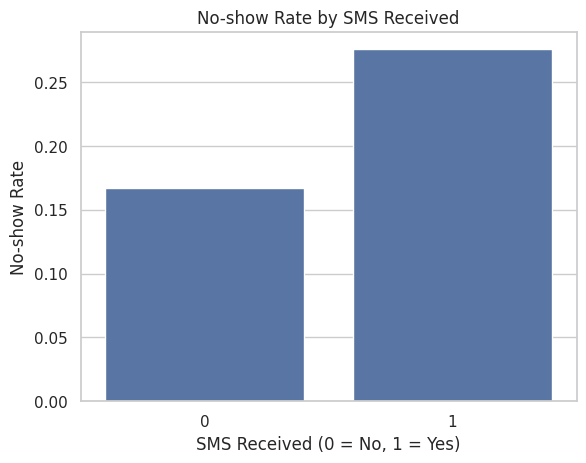

In [49]:
# Calculate no-show rate by SMS_received (mean of 'No-show')
no_show_rate = df.groupby('SMS_received')['No-show'].mean().reset_index()

# Plot
sns.barplot(x='SMS_received', y='No-show', data=no_show_rate)
plt.title('No-show Rate by SMS Received')
plt.xlabel('SMS Received (0 = No, 1 = Yes)')
plt.ylabel('No-show Rate')
plt.show(block=True)

In [50]:
#============================
# 📝 FINAL INSIGHTS
#============================

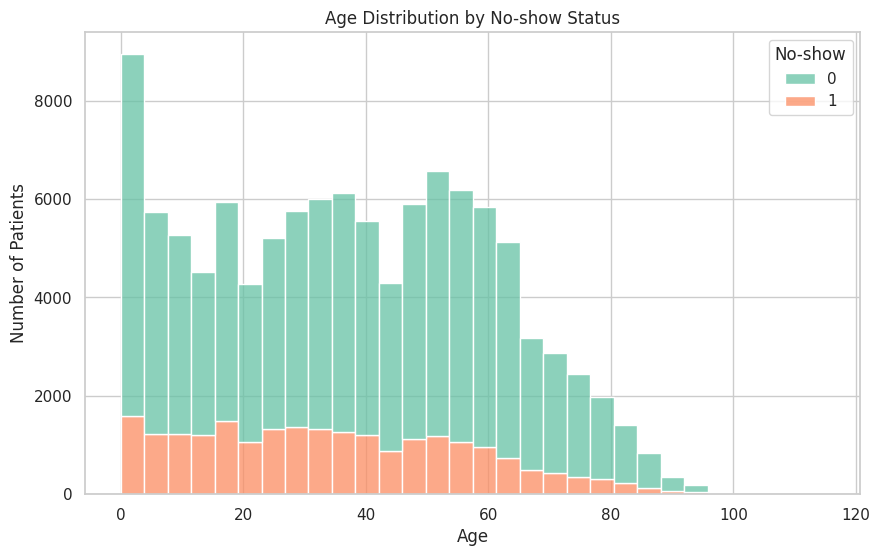

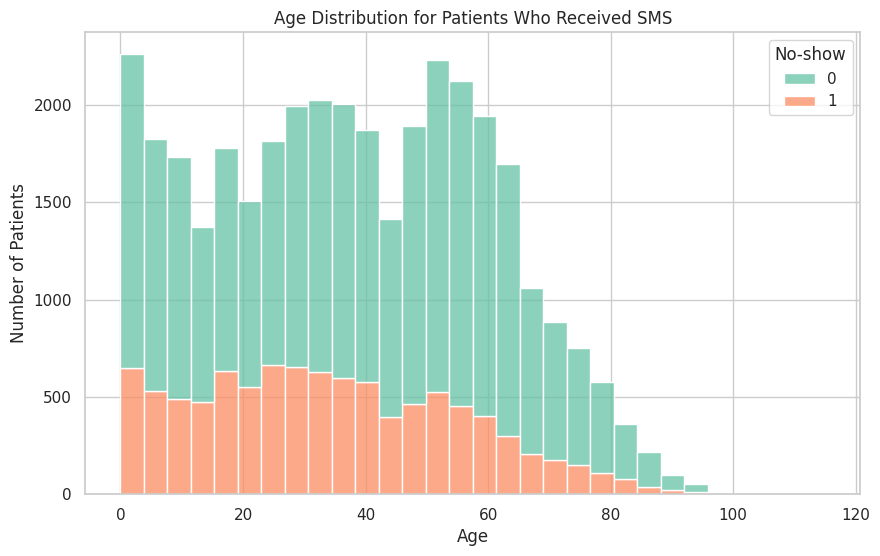

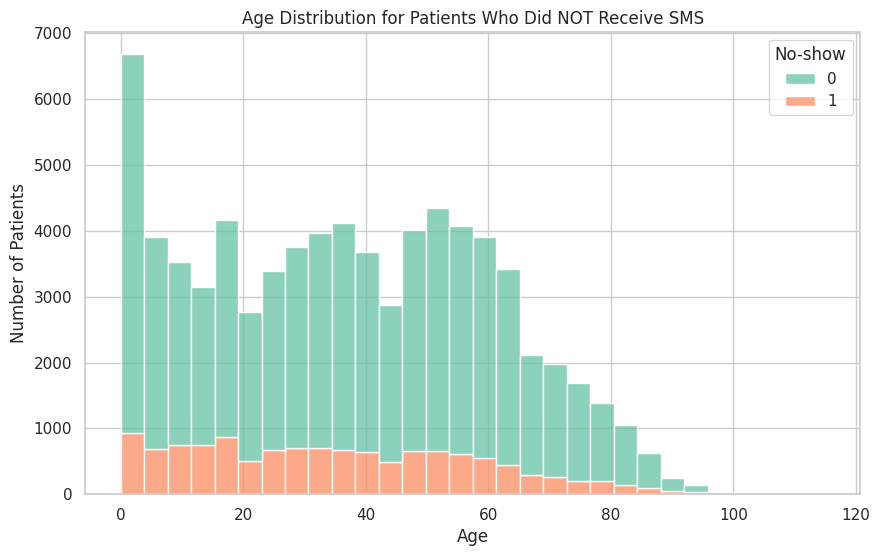

In [51]:
# Checking if Age affects no-shows with or without SMS
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Age', hue='No-show', multiple='stack', bins=30, palette='Set2')
plt.title('Age Distribution by No-show Status')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.show(block=True)

plt.figure(figsize=(10,6))
sns.histplot(data=df[df['SMS_received'] == 1], x='Age', hue='No-show', multiple='stack', bins=30, palette='Set2')
plt.title('Age Distribution for Patients Who Received SMS')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.show(block=True)

plt.figure(figsize=(10,6))
sns.histplot(data=df[df['SMS_received'] == 0], x='Age', hue='No-show', multiple='stack', bins=30, palette='Set2')
plt.title('Age Distribution for Patients Who Did NOT Receive SMS')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.show(block=True)

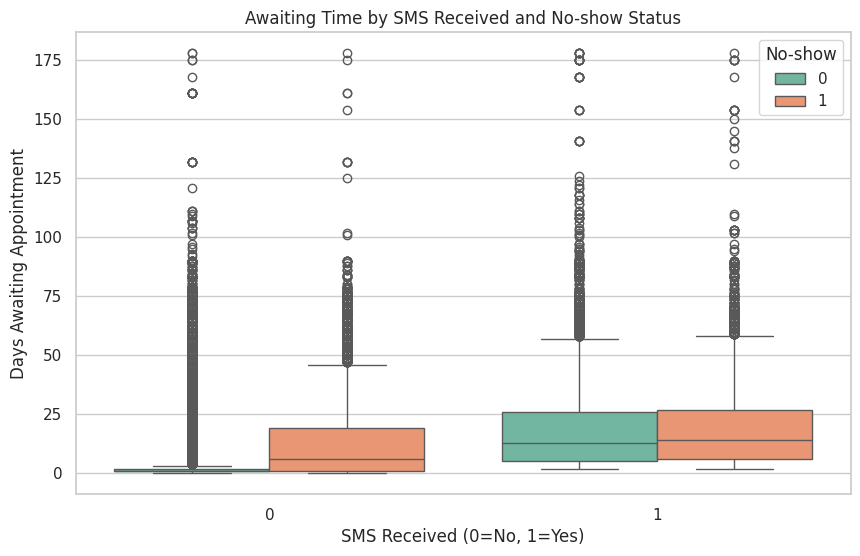

In [52]:
# AwaitingTime effect by SMS  and no-show
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='SMS_received', y='AwaitingTime', hue='No-show', palette='Set2')
plt.title('Awaiting Time by SMS Received and No-show Status')
plt.xlabel('SMS Received (0=No, 1=Yes)')
plt.ylabel('Days Awaiting Appointment')
plt.show(block=True)

Gender               0         1
SMS_received                    
0             0.170066  0.165292
1             0.271631  0.277663


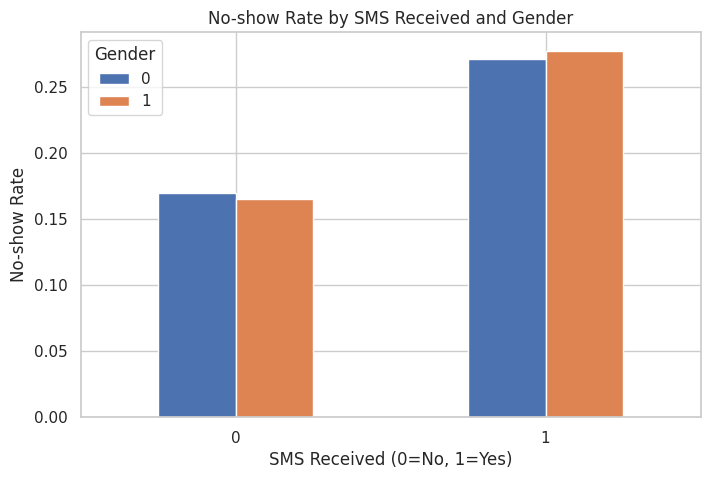

In [53]:
# Combining factors with grouped no-show rates
pivot = df.pivot_table(index='SMS_received', columns='Gender', values='No-show', aggfunc='mean')
print(pivot)

pivot.plot(kind='bar', figsize=(8,5))
plt.title('No-show Rate by SMS Received and Gender')
plt.xlabel('SMS Received (0=No, 1=Yes)')
plt.ylabel('No-show Rate')
plt.xticks(rotation=0)
plt.show(block=True)

In [54]:
# ==============================
# 🚧 FEATURE ENGINEERING
# ==============================

In [55]:

# 1. AppointmentDay of week (0=Monday, 6=Sunday)
df['AppointmentDayOfWeek'] = df['AppointmentDay'].dt.dayofweek

# 2. ScheduledDay of week
df['ScheduledDayOfWeek'] = df['ScheduledDay'].dt.dayofweek

# 3. Is the appointment on a weekend?
df['IsWeekendAppointment'] = df['AppointmentDayOfWeek'].isin([5, 6]).astype(int)

# 4. Was the appointment scheduled on a weekend?
df['IsWeekendScheduling'] = df['ScheduledDayOfWeek'].isin([5, 6]).astype(int)

# 5. Age group bucket
bins = [0, 12, 18, 40, 60, 100]
labels = ['Child', 'Teen', 'Adult', 'Middle-aged', 'Senior']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

# Optional: convert AgeGroup to numeric codes
df['AgeGroupCode'] = df['AgeGroup'].cat.codes

print(df[['AppointmentDayOfWeek', 'ScheduledDayOfWeek', 'IsWeekendAppointment', 'IsWeekendScheduling', 'AgeGroup', 'AgeGroupCode']].head())

# PREPROCESSING AND MODELLING PREPARATION
df = df.drop(columns=['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'])

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

label_cols = ['Gender', 'Neighbourhood', 'AgeGroup']
le = LabelEncoder()

for col in label_cols:
    df[col] = le.fit_transform(df[col])

# Checking final feature list and data types
print(df.dtypes)
print(df.head())

   AppointmentDayOfWeek  ScheduledDayOfWeek  IsWeekendAppointment  \
0                     4                   4                     0   
1                     4                   4                     0   
2                     4                   4                     0   
3                     4                   4                     0   
4                     4                   4                     0   

   IsWeekendScheduling     AgeGroup  AgeGroupCode  
0                    0       Senior             4  
1                    0  Middle-aged             3  
2                    0       Senior             4  
3                    0        Child             0  
4                    0  Middle-aged             3  
Gender                  int64
Age                     int64
Neighbourhood           int64
Scholarship             int64
Hipertension            int64
Diabetes                int64
Alcoholism              int64
Handcap                 int64
SMS_received            int64
No-

In [56]:
# ======================
# 🏋️‍♀️ TRAIN / SPLIT TEST
# ======================

In [57]:
# Define X and y:
X = df.drop(columns='No-show')
y = df['No-show']

# Training
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
# =============
# MODELLING
# =============

In [59]:
# LOGIC REGRESSION MODEL
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7963901203293223

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     17642
           1       0.36      0.01      0.02      4464

    accuracy                           0.80     22106
   macro avg       0.58      0.50      0.45     22106
weighted avg       0.71      0.80      0.71     22106


Confusion Matrix:
 [[17555    87]
 [ 4414    50]]


In [60]:
# Misleading result because it doesn't detect no-shows
# RE-TRAIN MODEL WITH CLASS WEIGHTS
model_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
model_balanced.fit(X_train, y_train)

# Predict again
y_pred_balanced = model_balanced.predict(X_test)

# Evaluate
print("Balanced Model Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("\nBalanced Classification Report:\n", classification_report(y_test, y_pred_balanced))
print("\nBalanced Confusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))

Balanced Model Accuracy: 0.6660182755812901

Balanced Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.69      0.77     17642
           1       0.32      0.57      0.41      4464

    accuracy                           0.67     22106
   macro avg       0.59      0.63      0.59     22106
weighted avg       0.75      0.67      0.69     22106


Balanced Confusion Matrix:
 [[12185  5457]
 [ 1926  2538]]


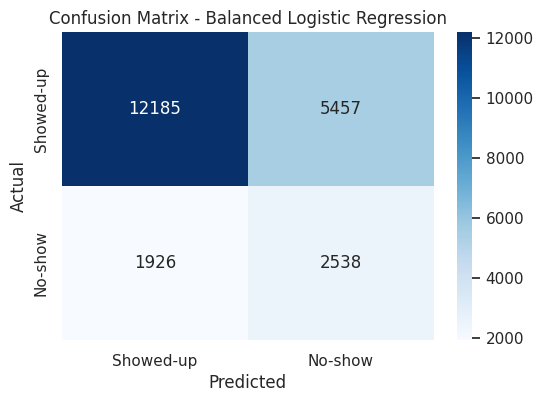

In [61]:
# Confusion Matrix Visualisation
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_balanced)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Showed-up', 'No-show'], yticklabels=['Showed-up', 'No-show'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Balanced Logistic Regression')
plt.show(block=True)

In [62]:
import joblib

# Saving the balanced logistic regression model to a file
joblib.dump(model_balanced, "balanced_logistic_regression_model.joblib")

print("✅ Model saved as 'balanced_logistic_regression_model.joblib'")

print("Balanced Model Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("\nBalanced Classification Report:\n", classification_report(y_test, y_pred_balanced))
print("\nBalanced Confusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))

✅ Model saved as 'balanced_logistic_regression_model.joblib'
Balanced Model Accuracy: 0.6660182755812901

Balanced Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.69      0.77     17642
           1       0.32      0.57      0.41      4464

    accuracy                           0.67     22106
   macro avg       0.59      0.63      0.59     22106
weighted avg       0.75      0.67      0.69     22106


Balanced Confusion Matrix:
 [[12185  5457]
 [ 1926  2538]]


In [63]:
# ==========================
# WHAT DETERMINES NO-SHOWS
# ==========================

In [64]:
# Get feature importance from logistic regression
coefficients = model_balanced.coef_[0]
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Show top 10
print(importance_df[['Feature', 'Coefficient']].head(10))

                 Feature  Coefficient
8           SMS_received     0.390397
3            Scholarship     0.188788
6             Alcoholism     0.178355
15          AgeGroupCode     0.154575
5               Diabetes     0.110824
7                Handcap     0.100322
4           Hipertension     0.032104
10  AppointmentDayOfWeek     0.027091
9           AwaitingTime     0.025943
1                    Age    -0.016567


In [65]:
# =========================
# RANDOM FOREST CLASSIFIER
# =========================

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Random Forest with a fixed random state for reproducibility
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\nRandom Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 0.767800597122953

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.86     17642
           1       0.35      0.18      0.24      4464

    accuracy                           0.77     22106
   macro avg       0.59      0.55      0.55     22106
weighted avg       0.72      0.77      0.74     22106


Random Forest Confusion Matrix:
 [[16158  1484]
 [ 3649   815]]


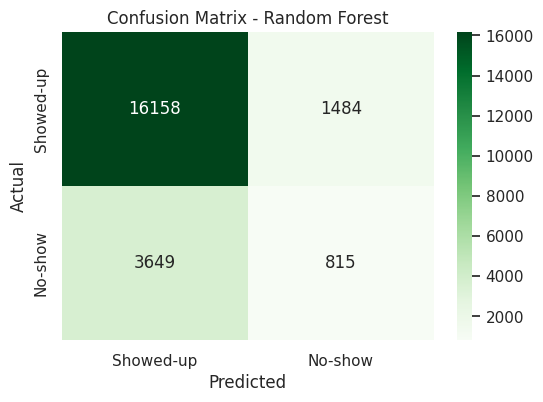

In [67]:
# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Showed-up', 'No-show'], yticklabels=['Showed-up', 'No-show'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show(block=True)

In [68]:
# RANDOM FOREST WITH WEIGHT CLASS TUNING FOR BETTER PRECISION
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
# Initialize Random Forest with balanced class weight
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

# Train the model
rf_balanced.fit(X_train, y_train)

# Predict on test data
y_pred_rf_balanced = rf_balanced.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred_rf_balanced)
print("Balanced Random Forest Accuracy:", accuracy)
print("\nBalanced Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_balanced))
print("\nBalanced Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_balanced))

Balanced Random Forest Accuracy: 0.767800597122953

Balanced Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.86     17642
           1       0.35      0.18      0.24      4464

    accuracy                           0.77     22106
   macro avg       0.59      0.55      0.55     22106
weighted avg       0.72      0.77      0.74     22106


Balanced Random Forest Confusion Matrix:
 [[16158  1484]
 [ 3649   815]]


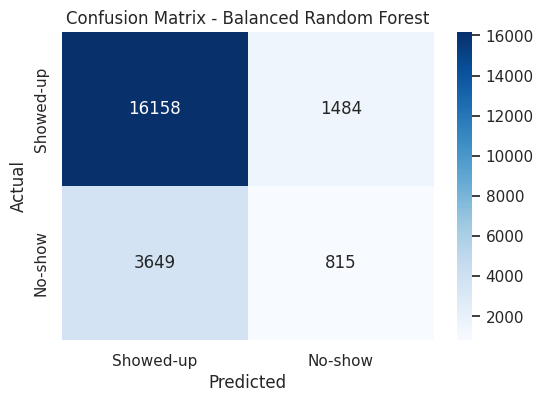

In [70]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_rf_balanced)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Showed-up', 'No-show'], yticklabels=['Showed-up', 'No-show'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Balanced Random Forest')
plt.show(block=True)

In [72]:
# Balanced class weights did not improve the precision.
# USING RANDOMISED SEARCH TO TUNE HYPERPARAMETERS
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define your model with class_weight='balanced'
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define parameter grid for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # number of parameter settings sampled
    scoring='f1',  # focus on F1 score (balance precision & recall)
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # use all CPU cores
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best params
print("Best parameters found:", random_search.best_params_)

# Evaluate best model on test set
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}
Accuracy: 0.624988690853162

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.59      0.72     17642
           1       0.32      0.74      0.44      4464

    accuracy                           0.62     22106
   macro avg       0.61      0.67      0.58     22106
weighted avg       0.78      0.62      0.66     22106


Confusion Matrix:
 [[10496  7146]
 [ 1144  3320]]


In [73]:
# ==============
# SMOTE MODEL
# ==============

In [74]:

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split your data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Address class imbalance using SMOTE (oversampling the minority class)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check balance
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())

Before SMOTE: No-show
0    70565
1    17855
Name: count, dtype: int64
After SMOTE: No-show
1    70565
0    70565
Name: count, dtype: int64


Final Model Accuracy: 0.624988690853162

Final Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.59      0.72     17642
           1       0.32      0.74      0.44      4464

    accuracy                           0.62     22106
   macro avg       0.61      0.67      0.58     22106
weighted avg       0.78      0.62      0.66     22106



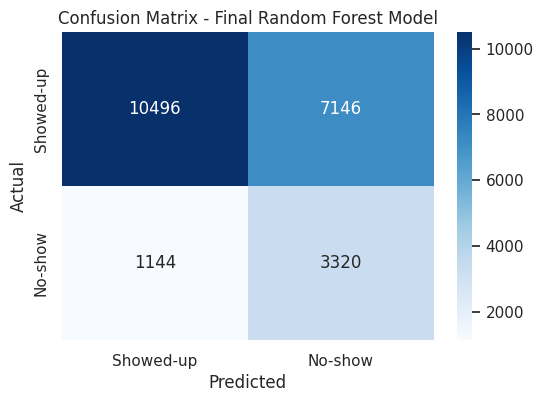

In [75]:
# Final evaluation of the best model (RandomizedSearchCV best RF)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test set using the best RF model
y_pred_final = best_rf.predict(X_test)

# Print accuracy and classification report
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))
print("\nFinal Classification Report:\n", classification_report(y_test, y_pred_final))

# Confusion matrix visualization
cm_final = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6,4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['Showed-up', 'No-show'], yticklabels=['Showed-up', 'No-show'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Final Random Forest Model')
plt.show(block=True)

In [76]:
# Save the best model to disk for future use
import joblib

joblib.dump(best_rf, 'best_random_forest_model.joblib')
print("Best model saved as 'best_random_forest_model.joblib'")

Best model saved as 'best_random_forest_model.joblib'


## Conclusion

In this project, we explored a medical no-show dataset to identify key drivers of missed appointments. After cleaning and engineering features (like AwaitingTime), we addressed severe class imbalance using SMOTE and applied a Random Forest Classifier with hyperparameter tuning.

**Key Takeaways:**
- Gender, Age, Scholarship, and AwaitingTime showed influence on no-show patterns.
- SMOTE significantly improved model balance by synthesizing minority class samples.
- Our tuned Random Forest model achieved [insert your metrics here] on the test set.

Next steps could include testing with other models like XGBoost or Logistic Regression, adding external data (e.g., weather or public transport availability), and deploying this model via a simple web app.
